<a href="https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/tf_serving_sd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/keras-team/keras-cv -q

In [ ]:
import time
import base64
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
keras_cv.__version__

'0.3.5'

In [ ]:
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.decoder import Decoder

In [ ]:
MAX_PROMPT_LENGTH = 77
IMG_HEIGHT = 512
IMG_WIDTH = 512

text_encoder = TextEncoder(MAX_PROMPT_LENGTH)
diffusion_model = DiffusionModel(IMG_HEIGHT, IMG_WIDTH, MAX_PROMPT_LENGTH)
decoder = Decoder(IMG_HEIGHT, IMG_WIDTH)

198180272/198180272 [==============================] - 1s 0us/step


## Diffusion model (that generates the latent)

In [ ]:
from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD
import tensorflow as tf

signature_dict = {
    "context": tf.TensorSpec(shape=[None, 77, 768], dtype=tf.float32, name="context"),
    "unconditional_context": tf.TensorSpec(
        shape=[None, 77, 768], dtype=tf.float32, name="unconditional_context"
    ),
    "num_steps": tf.TensorSpec(shape=[], dtype=tf.int32, name="num_steps"),
    "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}


def diffusion_model_exporter(model: tf.keras.Model):
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    MAX_PROMPT_LENGTH = 77
    _ALPHAS_CUMPROD_tf = tf.constant(_ALPHAS_CUMPROD)
    UNCONDITIONAL_GUIDANCE_SCALE = 7.5
    SEED = None

    @tf.function
    def get_timestep_embedding(timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return tf.repeat(embedding, batch_size, axis=0)

    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        img_height = tf.cast(tf.math.round(IMG_HEIGHT / 128) * 128, tf.int32)
        img_width = tf.cast(tf.math.round(IMG_WIDTH / 128) * 128, tf.int32)

        batch_size = inputs["batch_size"]
        num_steps = inputs["num_steps"]

        context = inputs["context"]
        unconditional_context = inputs["unconditional_context"]

        latent = tf.random.normal((batch_size, img_height // 8, img_width // 8, 4))

        timesteps = tf.range(1, 1000, 1000 // num_steps)
        alphas = tf.map_fn(lambda t: _ALPHAS_CUMPROD_tf[t], timesteps, dtype=tf.float32)
        alphas_prev = tf.concat([[1.0], alphas[:-1]], 0)

        index = num_steps - 1
        latent_prev = None
        for timestep in timesteps[::-1]:
            latent_prev = latent
            t_emb = get_timestep_embedding(timestep, batch_size)
            unconditional_latent = model(
                [latent, t_emb, unconditional_context], training=False
            )
            latent = model([latent, t_emb, context], training=False)
            latent = unconditional_latent + UNCONDITIONAL_GUIDANCE_SCALE * (
                latent - unconditional_latent
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            pred_x0 = (latent_prev - tf.math.sqrt(1 - a_t) * latent) / tf.math.sqrt(a_t)
            latent = (
                latent * tf.math.sqrt(1.0 - a_prev) + tf.math.sqrt(a_prev) * pred_x0
            )
            index = index - 1

        return {"latent": latent}

    return serving_fn

In [ ]:
tf.saved_model.save(
    diffusion_model,
    "./diffusion_model/1/",
    signatures={"serving_default": diffusion_model_exporter(diffusion_model)},
)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
!saved_model_cli show --dir diffusion_model/1/ --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['batch_size'] tensor_info:
      dtype: DT_INT32
      shape: ()
      name: serving_default_batch_size:0
  inputs['context'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 77, 768)
      name: serving_default_context:0
  inputs['num_steps'] tensor_info:
      dtype: DT_INT32
      shape: ()
      name: serving_default_num_steps:0
  inputs['unconditional_context'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 77, 768)
      name: serving_default_unconditional_context:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['latent'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 64, 64, 4)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
from tensorflow.python.saved_model import tag_constants

saved_model_loaded = tf.saved_model.load(
    "./diffusion_model/1/", tags=[tag_constants.SERVING]
)
predict_fn = saved_model_loaded.signatures["serving_default"]

In [ ]:
saved_model_loaded.signatures["serving_default"].structured_outputs

{'latent': TensorSpec(shape=(None, 64, 64, 4), dtype=tf.float32, name='latent')}

In [ ]:
batch_size = tf.constant(2)
context = tf.random.normal((batch_size, 77, 768))
num_steps = tf.constant(10)
unconditional_context = tf.random.normal((batch_size, 77, 768))
latent = tf.random.normal((batch_size, 64, 64, 4))

In [ ]:
predict_fn(
    batch_size=batch_size,
    context=context,
    num_steps=num_steps,
    unconditional_context=unconditional_context,
)

{'latent': <tf.Tensor: shape=(2, 64, 64, 4), dtype=float32, numpy=
 array([[[[-0.0551571 , -0.62371576,  0.2432121 ,  0.60353845],
          [-0.49509624, -0.17084345, -0.48897856, -0.605322  ],
          [-0.7740532 ,  0.1940194 , -0.19547874, -0.292185  ],
          ...,
          [-0.65868145, -0.21213776, -0.842944  , -0.5540791 ],
          [-1.1106727 , -0.52800596, -0.5471809 , -1.2734349 ],
          [-0.7991772 ,  0.07505807, -0.3235713 , -0.596548  ]],
 
         [[-0.16732258, -0.09192549,  1.2331913 ,  0.8507723 ],
          [-0.656552  , -0.0036163 ,  0.23750955, -0.06349215],
          [-0.35003555, -0.05758369,  0.6771852 , -0.32909057],
          ...,
          [-0.49506995,  0.47734454, -0.45965496, -0.25305972],
          [-0.79190886,  0.55438364, -0.0540843 , -0.02084279],
          [-0.65334815, -0.6442001 , -0.77740896, -0.54494536]],
 
         [[-0.8634907 ,  0.01913147, -0.3541243 , -0.06424535],
          [-0.33030033, -0.39592358,  0.77371806,  0.09815185],
 

## Decoder

In [ ]:
signature_dict = {
    "latent": tf.TensorSpec(shape=[None, 64, 64, 4], dtype=tf.float32, name="latent"),
}


def decoder_exporter(model: tf.keras.Model):
    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        latent = inputs["latent"]
        decoded = model(latent, training=False)
        decoded = ((decoded + 1) / 2) * 255
        images = tf.clip_by_value(decoded, 0, 255)
        images = tf.cast(images, tf.uint8)
        return {"generated_images": images}

    return serving_fn

In [ ]:
tf.saved_model.save(
    decoder,
    "./decoder/1/",
    signatures={"serving_default": decoder_exporter(decoder)},
)

In [ ]:
saved_model_loaded = tf.saved_model.load("./decoder/1/", tags=[tag_constants.SERVING])
decoder_predict_fn = saved_model_loaded.signatures["serving_default"]

In [ ]:
decoder_predict_fn(latent=tf.random.normal((int(batch_size), 64, 64, 4)))

{'generated_images': <tf.Tensor: shape=(2, 512, 512, 3), dtype=uint8, numpy=
 array([[[[100,  92,  74],
          [108,  93,  77],
          [119,  89,  77],
          ...,
          [ 56,  85, 120],
          [ 87,  98, 114],
          [ 95,  98, 109]],
 
         [[ 89,  78,  65],
          [ 64,  53,  56],
          [ 65,  67,  62],
          ...,
          [ 57,  92, 154],
          [ 48,  67, 108],
          [ 69,  75, 100]],
 
         [[ 89,  83,  66],
          [ 40,  32,  42],
          [ 31,  28,  33],
          ...,
          [ 55, 112, 227],
          [ 58,  92, 164],
          [ 55,  61,  96]],
 
         ...,
 
         [[190, 165, 147],
          [239, 207, 201],
          [222, 188, 196],
          ...,
          [ 44, 101, 165],
          [ 13,  29,  67],
          [ 44,  36,  46]],
 
         [[173, 139, 127],
          [206, 174, 168],
          [208, 172, 174],
          ...,
          [ 62,  98, 141],
          [ 28,  43,  69],
          [ 59,  58,  61]],
 
       

## Text encoder + tokenizer

The Tokenizer uses pure Python utilities and hence probably cannot be immediately serialized into a `tf.function`. 

In [ ]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS

In [ ]:
signature_dict = {
    "tokens": tf.TensorSpec(shape=[None, 77], dtype=tf.int32, name="tokens"),
    "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}


def text_encoder_exporter(model: tf.keras.Model):
    MAX_PROMPT_LENGTH = 77
    POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)
    UNCONDITIONAL_TOKENS = tf.convert_to_tensor([_UNCONDITIONAL_TOKENS], dtype=tf.int32)

    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        batch_size = inputs["batch_size"]

        # context
        encoded_text = model([inputs["tokens"], POS_IDS], training=False)
        encoded_text = tf.squeeze(encoded_text)

        if tf.rank(encoded_text) == 2:
            encoded_text = tf.repeat(
                tf.expand_dims(encoded_text, axis=0), batch_size, axis=0
            )

        # unconditional context
        unconditional_context = model([UNCONDITIONAL_TOKENS, POS_IDS], training=False)

        unconditional_context = tf.repeat(unconditional_context, batch_size, axis=0)
        return {"context": encoded_text, "unconditional_context": unconditional_context}

    return serving_fn

In [ ]:
tf.saved_model.save(
    text_encoder,
    "./text_encoder/1/",
    signatures={"serving_default": text_encoder_exporter(text_encoder)},
)

In [ ]:
saved_model_loaded = tf.saved_model.load(
    "./text_encoder/1/", tags=[tag_constants.SERVING]
)
text_encoder_predict_fn = saved_model_loaded.signatures["serving_default"]

In [ ]:
text_encoder_predict_fn(
    tokens=tf.ones((int(batch_size), 77), tf.int32), batch_size=batch_size
)

{'context': <tf.Tensor: shape=(2, 77, 768), dtype=float32, numpy=
 array([[[-0.3346261 ,  0.01009526, -0.03909908, ..., -0.47089773,
          -0.29982755,  0.04647393],
         [ 1.506624  , -0.21650706,  1.2636553 , ...,  0.00335795,
           0.6349709 , -1.3449414 ],
         [ 1.7516767 , -0.66235316,  2.074435  , ..., -1.3681626 ,
           0.42679894, -1.0833032 ],
         ...,
         [ 1.3720874 , -0.36618185,  0.4507538 , ...,  0.80407566,
          -0.26381162, -1.8110058 ],
         [ 1.3309753 , -0.44742727,  0.40844196, ...,  0.8363533 ,
          -0.38667285, -1.7850467 ],
         [ 1.5815113 , -0.36975542,  0.28679246, ...,  0.8211694 ,
          -0.4713105 , -1.8488036 ]],
 
        [[-0.3346261 ,  0.01009526, -0.03909908, ..., -0.47089773,
          -0.29982755,  0.04647393],
         [ 1.506624  , -0.21650706,  1.2636553 , ...,  0.00335795,
           0.6349709 , -1.3449414 ],
         [ 1.7516767 , -0.66235316,  2.074435  , ..., -1.3681626 ,
           0.42679

## An end-to-end example

In [ ]:
tokenizer = SimpleTokenizer()
prompt = "photograph of an astronaut riding a horse in a green desert"
tokens = tokenizer.encode(prompt)

### Tokenize

In [ ]:
padding_token = 49407

tokens = tokens + [padding_token] * (MAX_PROMPT_LENGTH - len(tokens))
tokens = tf.convert_to_tensor([tokens], dtype=tf.int32)
tokens.shape

TensorShape([1, 77])

### Encode

In [ ]:
batch_size = tf.constant(4)  # Denotes how many images to generate.

encoded_text = text_encoder_predict_fn(
    tokens=tokens,
    batch_size=batch_size,
)

### Generate the latents

In [ ]:
num_steps = 25

latents = predict_fn(
    batch_size=batch_size,
    context=encoded_text["context"],
    num_steps=tf.convert_to_tensor(num_steps),
    unconditional_context=encoded_text["unconditional_context"],
)

### Decode the latents

In [ ]:
latents.keys()

dict_keys(['latent'])

In [ ]:
decoded_images = decoder_predict_fn(latent=latents["latent"])

decoded_images["generated_images"].shape

TensorShape([4, 512, 512, 3])

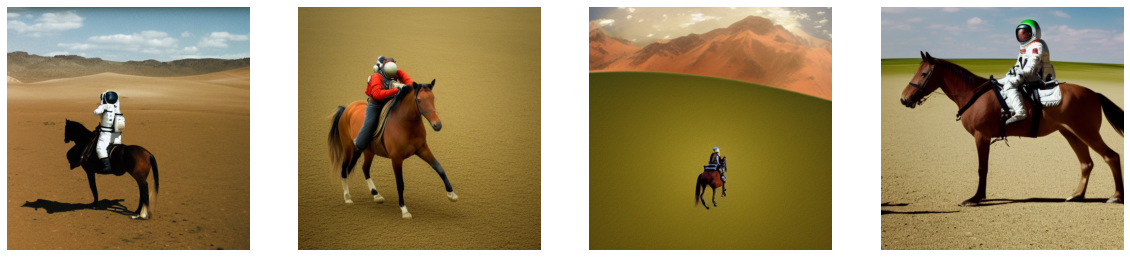

In [ ]:
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(decoded_images["generated_images"].numpy())

### Putting things together in a function

In [ ]:
import numpy as np

In [ ]:
PADDING_TOKEN = 49407


def generate_images_from_text(
    text: str, batch_size: int = 4, num_steps: int = 25
) -> np.ndarray:
    batch_size = tf.constant(batch_size)
    num_steps = tf.constant(num_steps)

    tokens = tokenizer.encode(text)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    tokens = tf.convert_to_tensor([tokens], dtype=tf.int32)

    encoded_text = text_encoder_predict_fn(
        tokens=tokens,
        batch_size=batch_size,
    )

    latents = predict_fn(
        batch_size=batch_size,
        context=encoded_text["context"],
        num_steps=num_steps,
        unconditional_context=encoded_text["unconditional_context"],
    )

    decoded_images = decoder_predict_fn(latent=latents["latent"])
    return decoded_images["generated_images"].numpy()

In [ ]:
plot_images(generate_images_from_text("An image of a squirrel in Picasso style"))

![](https://i.ibb.co/LS3WNhN/image.png)